In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

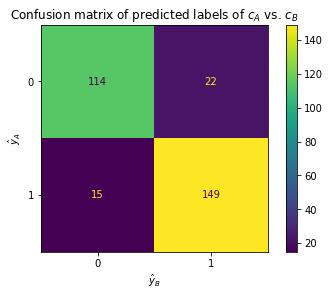

In [4]:
comparer.plot_confusion_matrix(X)

# Global explanations

In [5]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [6]:
focus_class = '(0, 1)'

In [7]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 44.1 s, sys: 377 ms, total: 44.5 s
Wall time: 49.9 s


In [8]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [9]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [10]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [11]:
feature_importances = tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

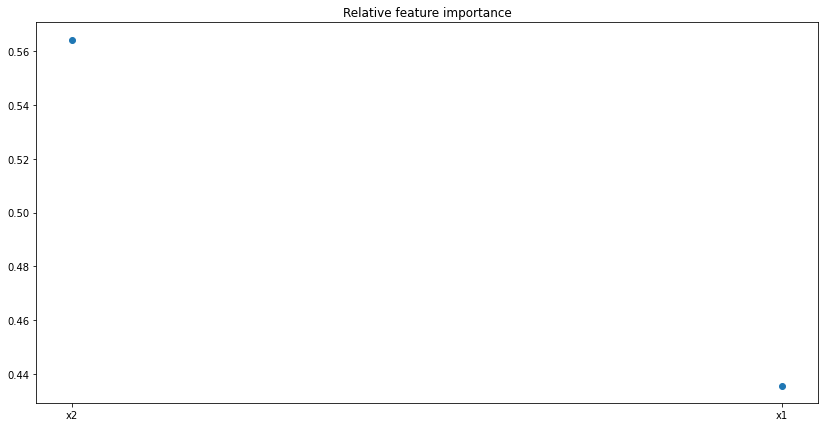

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

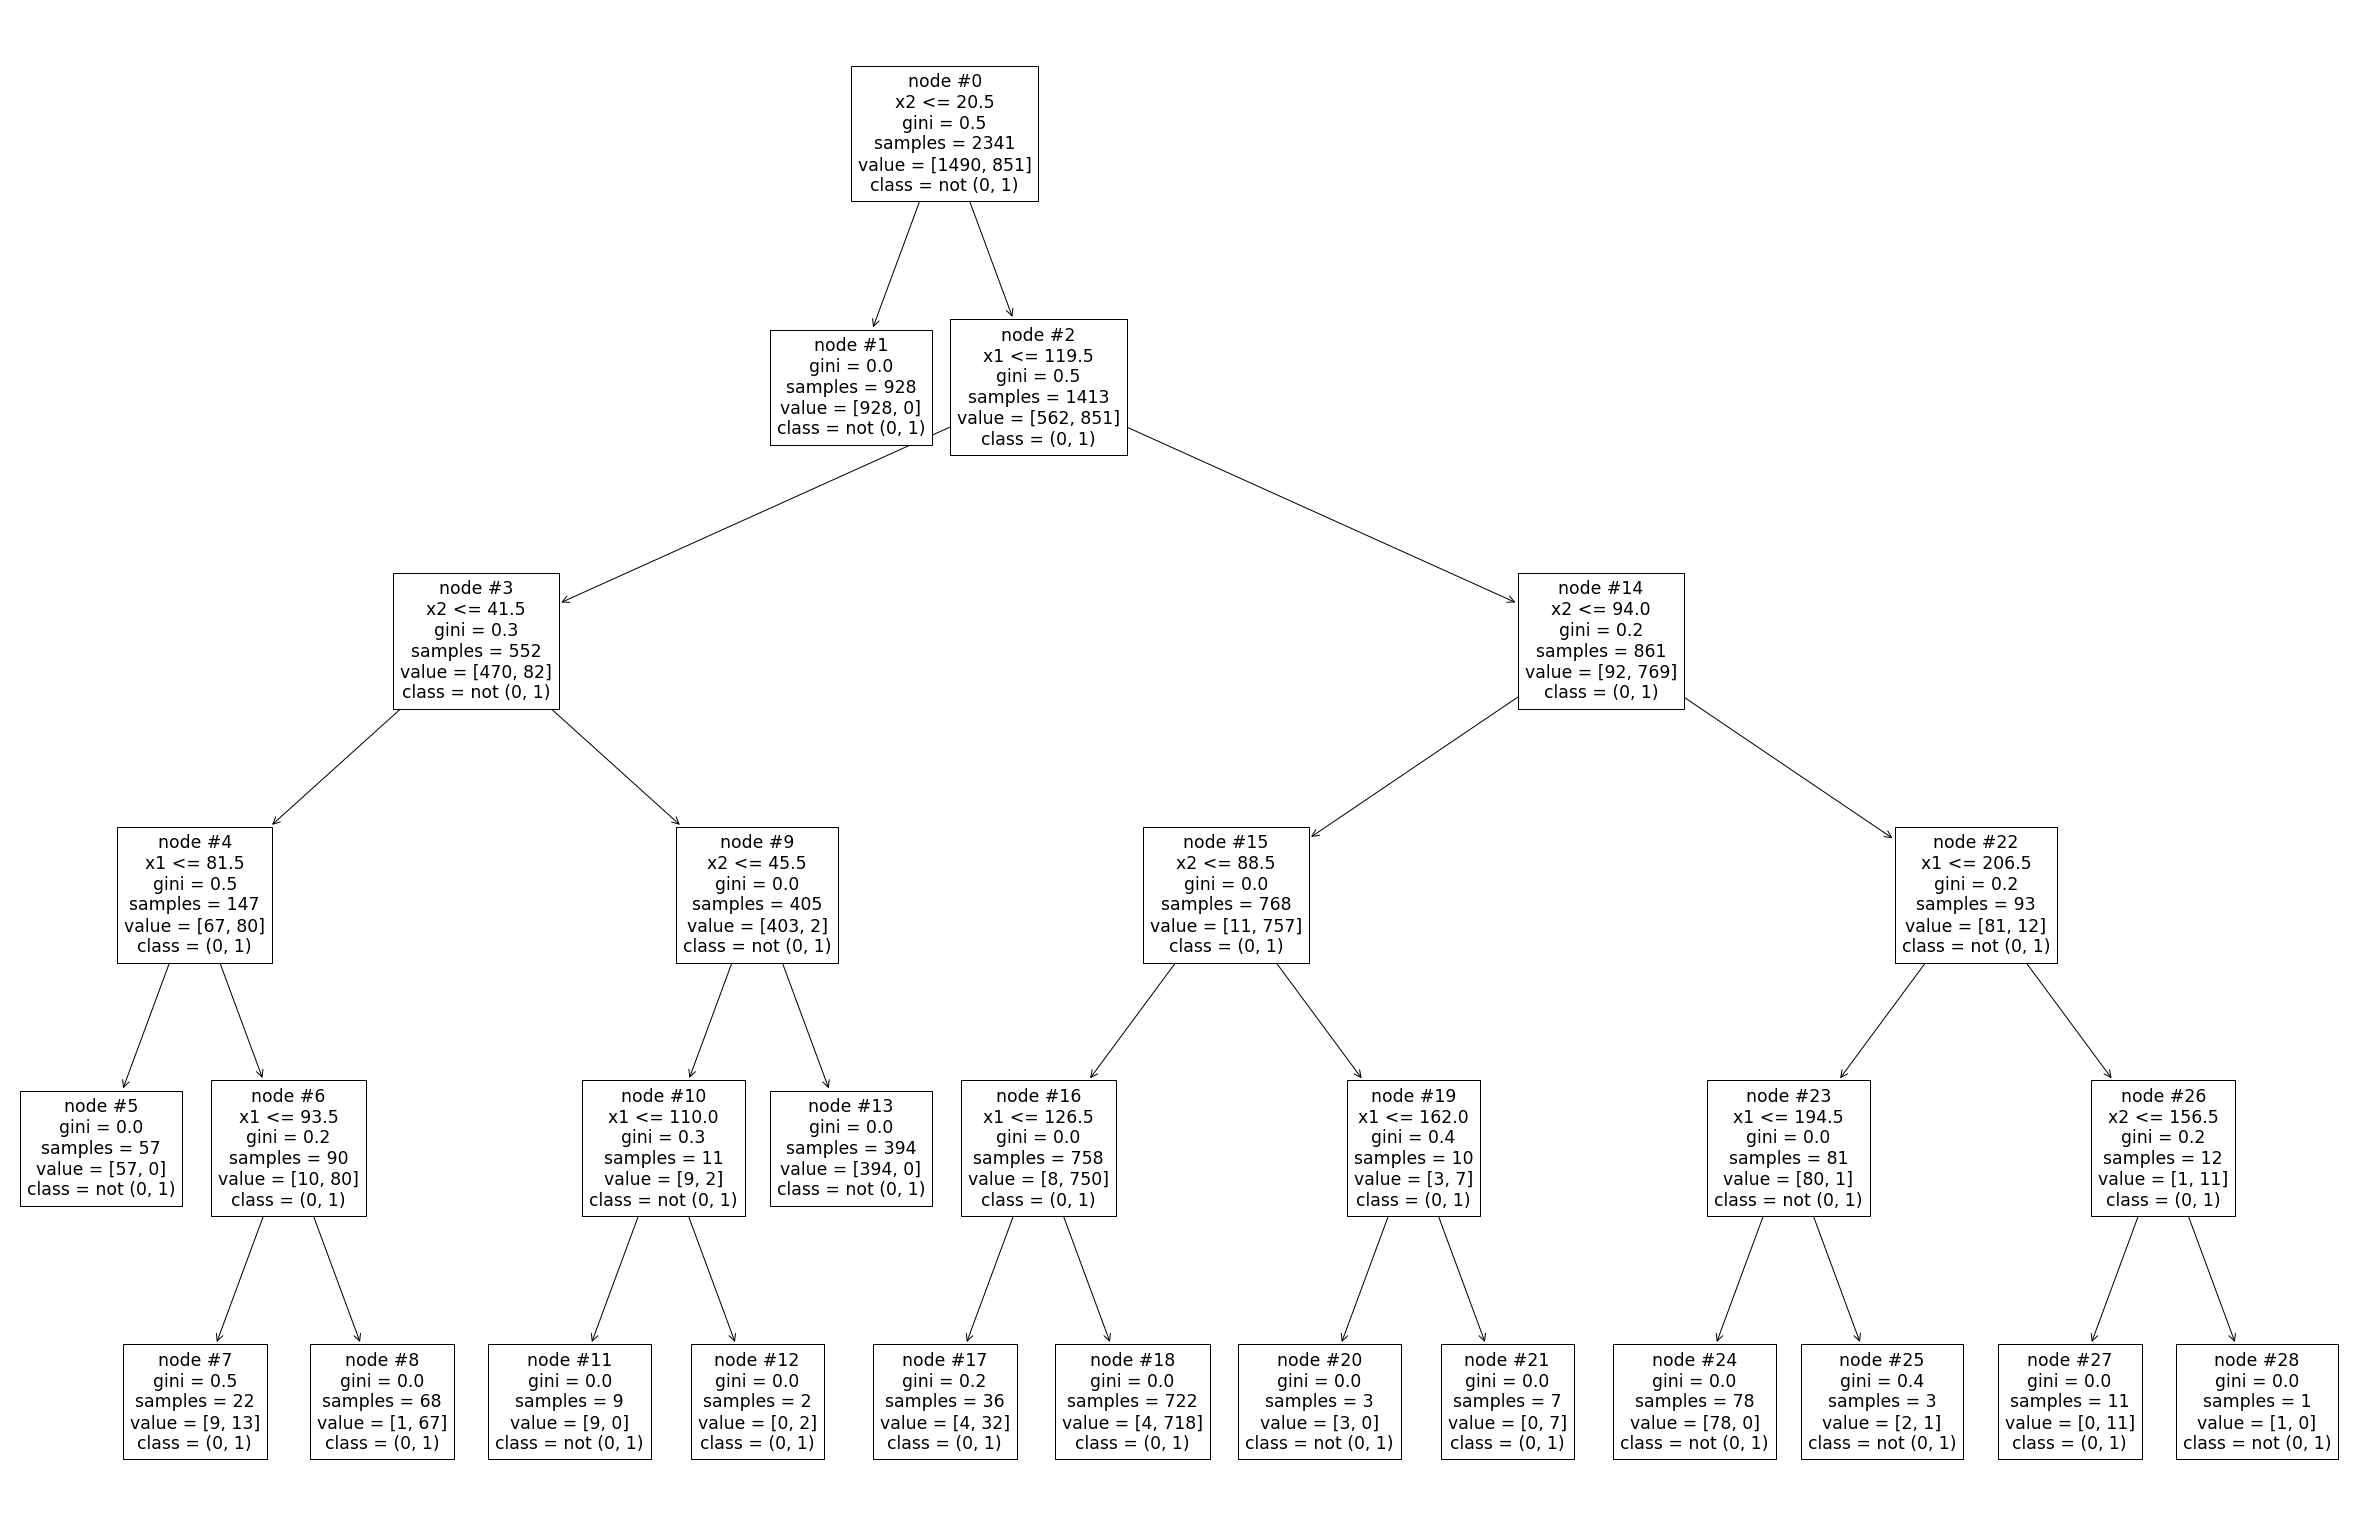

In [15]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [14]:
print_rules(tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #18: if (x2 > 20.5) and (x2 <= 88.5) and (x1 > 126.5) then class: (0, 1) (718/722 instances)
node #8: if (x2 > 20.5) and (x2 <= 41.5) and (x1 > 93.5) and (x1 <= 119.5) then class: (0, 1) (67/68 instances)
node #17: if (x2 > 20.5) and (x2 <= 88.5) and (x1 > 119.5) and (x1 <= 126.5) then class: (0, 1) (32/36 instances)
node #7: if (x2 > 20.5) and (x2 <= 41.5) and (x1 > 81.5) and (x1 <= 93.5) then class: (0, 1) (13/22 instances)
node #27: if (x2 > 94.0) and (x2 <= 156.5) and (x1 > 206.5) then class: (0, 1) (11/11 instances)
node #21: if (x2 > 88.5) and (x2 <= 94.0) and (x1 > 162.0) then class: (0, 1) (7/7 instances)
node #12: if (x2 > 41.5) and (x2 <= 45.5) and (x1 > 110.0) and (x1 <= 119.5) then class: (0, 1) (2/2 instances)


In [16]:
pd.Series(class_names[y_explain]).value_counts()

not (0, 1)    1490
(0, 1)         851
dtype: int64

In [20]:
(718+67)/851

0.9224441833137486

In [21]:
indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
pred_nodes = tree.apply(X[indices])
pd.Series(pred_nodes).value_counts()

18    14
8      4
27     4
dtype: int64

In [22]:
(14+4)/22

0.8181818181818182

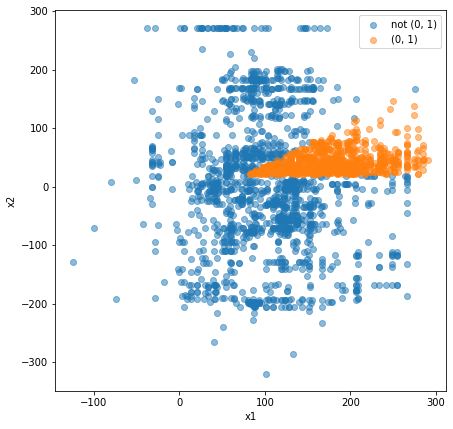

In [23]:
plot_diro2c_2d(explanation, 'x1', 'x2')

## $(1,0)$

In [24]:
focus_class = '(1, 0)'

In [25]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 40.7 s, sys: 239 ms, total: 40.9 s
Wall time: 41.7 s


In [26]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [27]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']

In [28]:
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_explain, y_explain)
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [29]:
feature_importances = tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

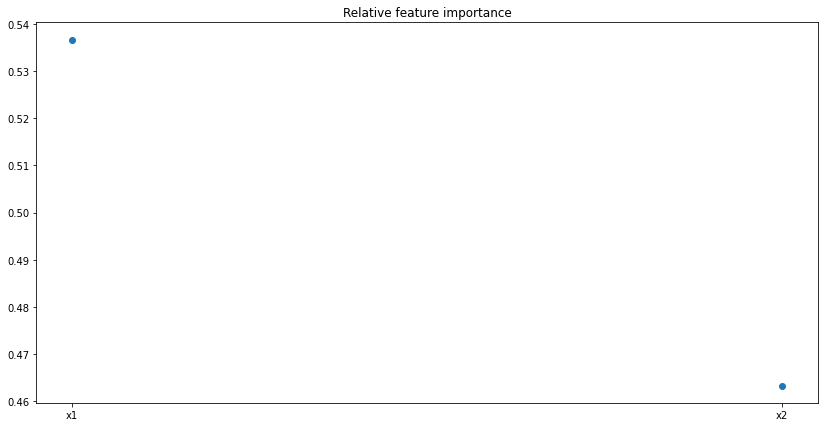

In [30]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

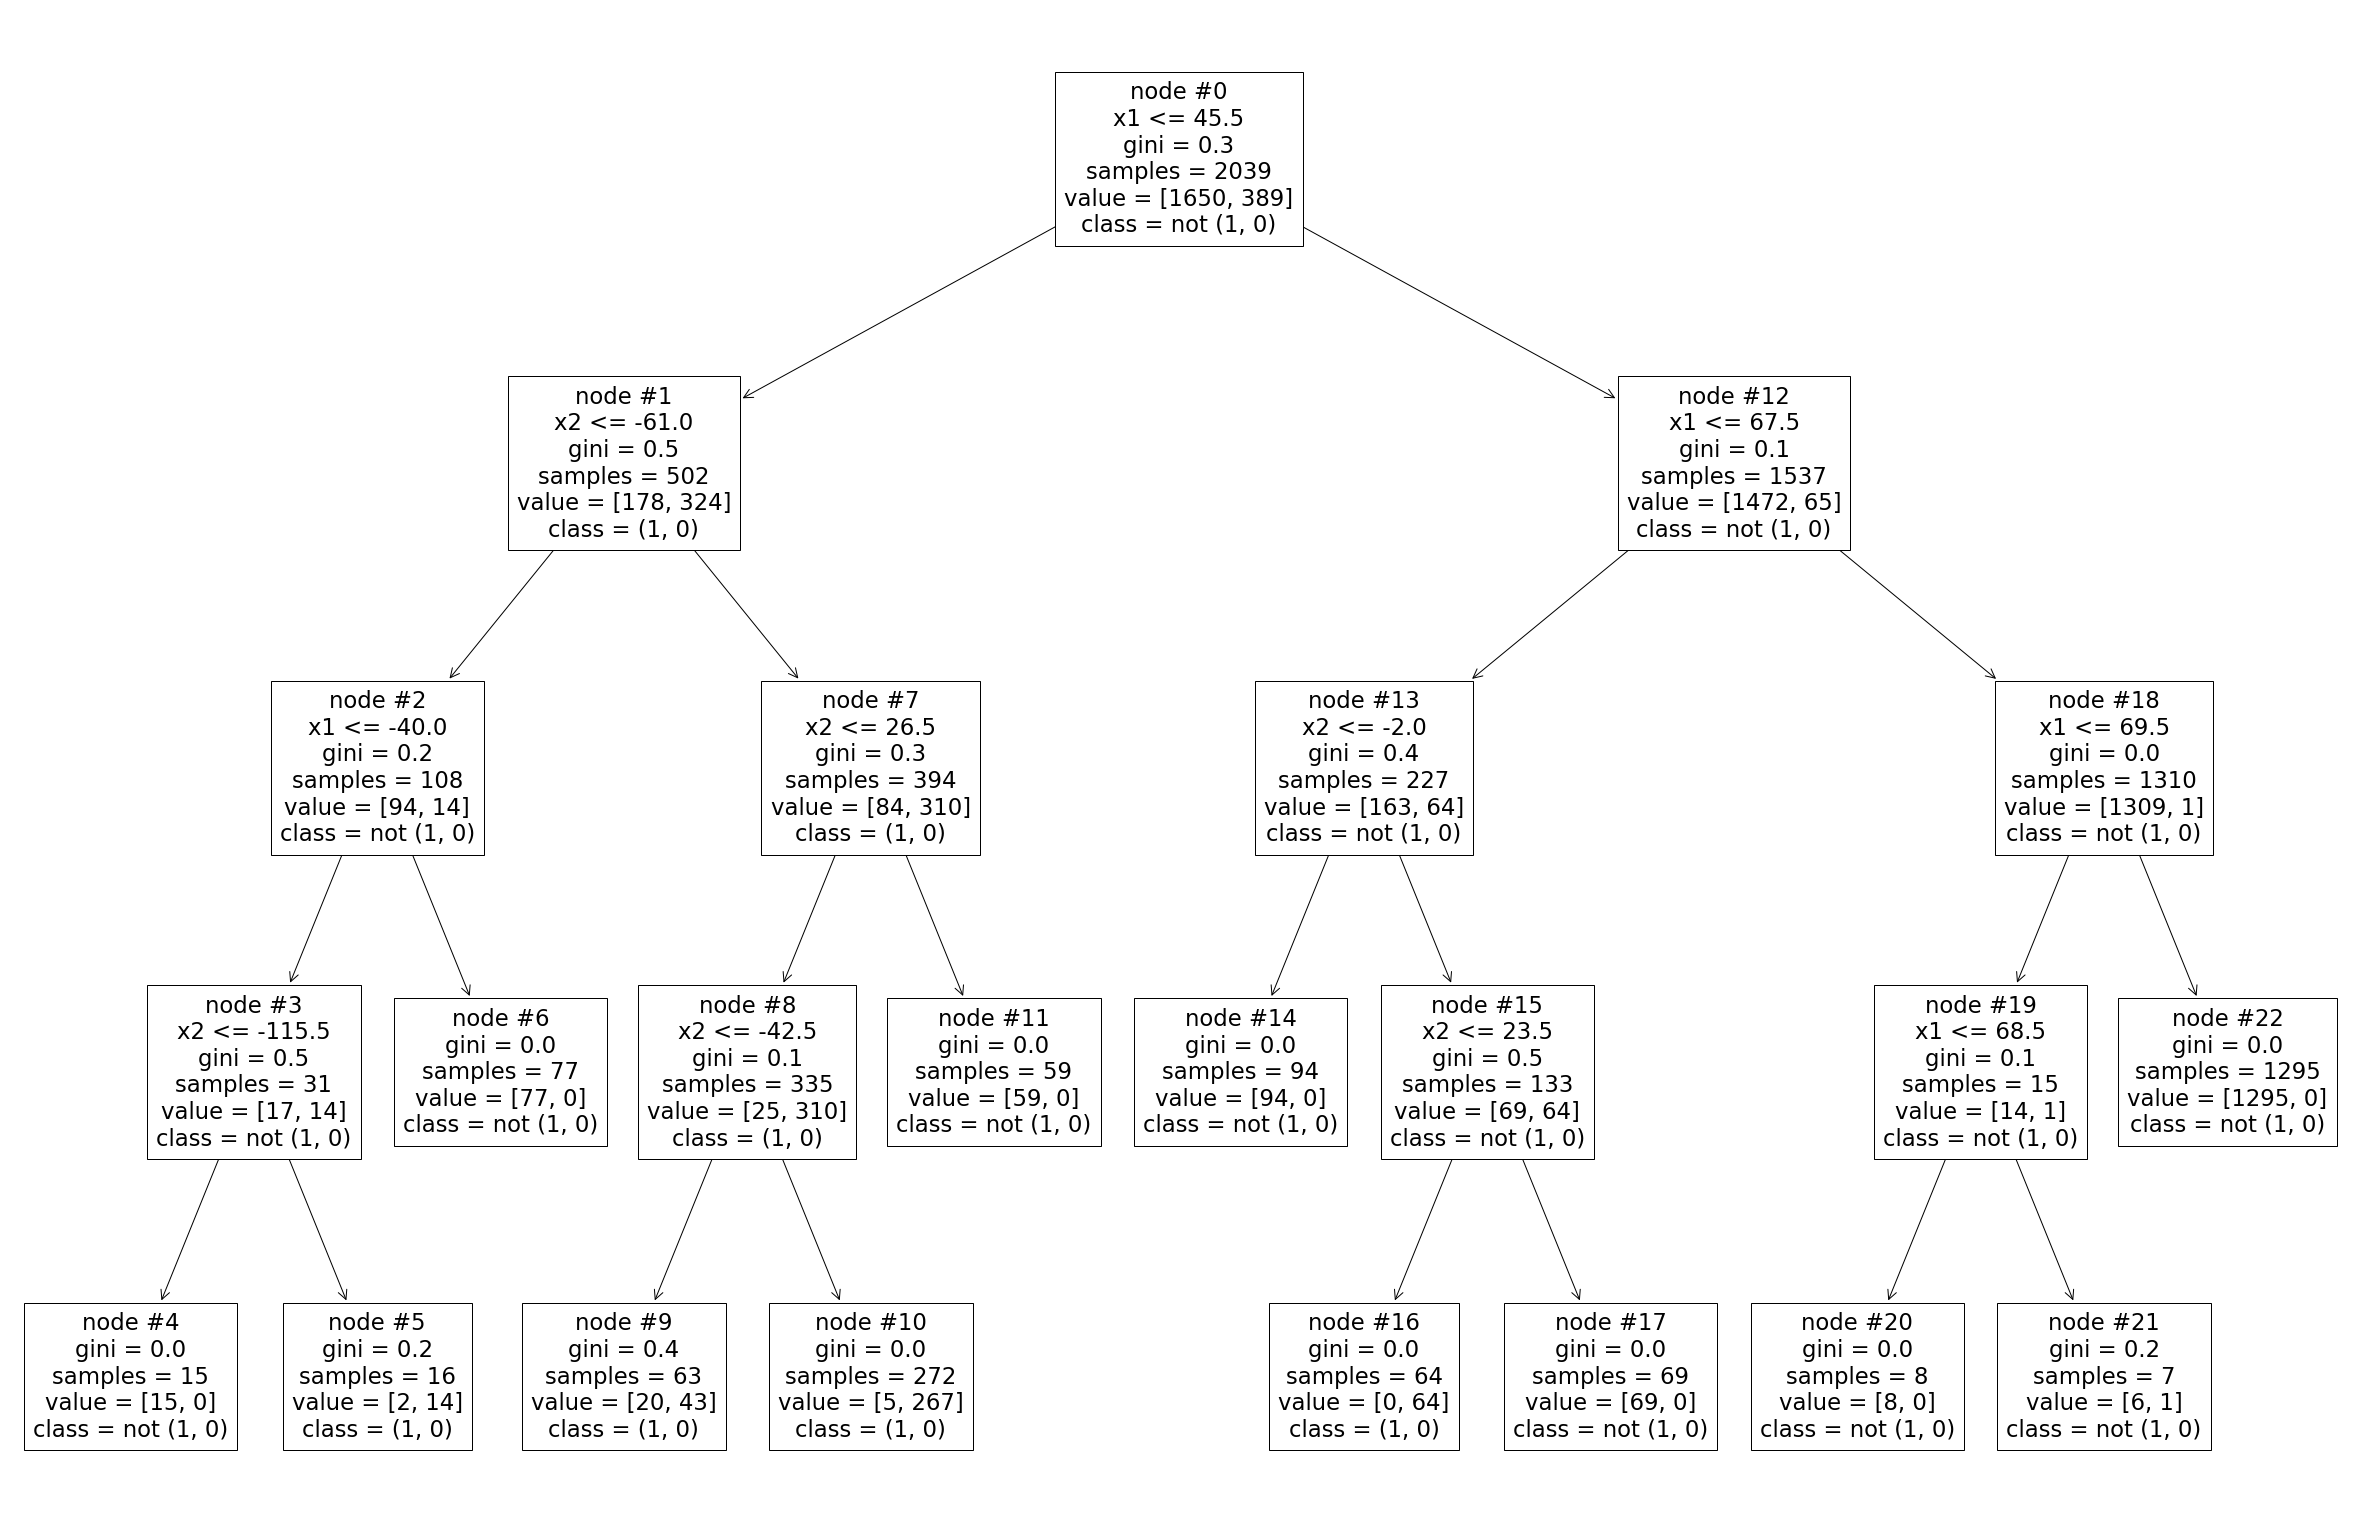

In [31]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [32]:
print_rules(tree, feature_names, class_names, focus_class, feature_order, precision=2)

node #10: if (x1 <= 45.5) and (x2 > -42.5) and (x2 <= 26.5) then class: (1, 0) (267/272 instances)
node #16: if (x1 > 45.5) and (x1 <= 67.5) and (x2 > -2.0) and (x2 <= 23.5) then class: (1, 0) (64/64 instances)
node #9: if (x1 <= 45.5) and (x2 > -61.0) and (x2 <= -42.5) then class: (1, 0) (43/63 instances)
node #5: if (x1 <= -40.0) and (x2 > -115.5) and (x2 <= -61.0) then class: (1, 0) (14/16 instances)


In [33]:
pd.Series(class_names[y_explain]).value_counts()

not (1, 0)    1650
(1, 0)         389
dtype: int64

In [37]:
(267+64)/389

0.8508997429305912

In [35]:
indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]
pred_nodes = tree.apply(X[indices])
pd.Series(pred_nodes).value_counts()

10    13
16     2
dtype: int64

In [36]:
(13+2)/15

1.0

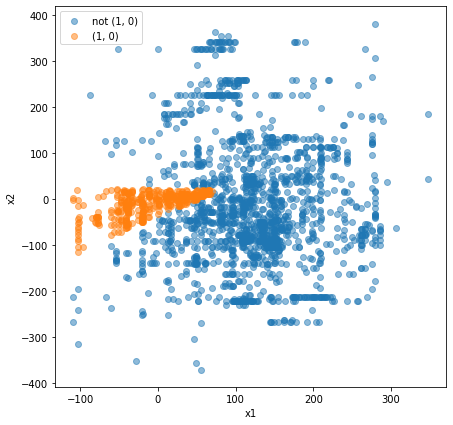

In [38]:
plot_diro2c_2d(explanation, 'x1', 'x2')